In [1]:
# Import the necessary modules and libraries
import pandas as pd
import numpy as np
import pickle
import glob
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Flatten
from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras
from keras.utils.vis_utils import plot_model
import matplotlib.pyplot as plt

2023-05-23 13:56:55.937909: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-23 13:56:56.252572: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-05-23 13:56:56.301533: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-05-23 13:56:56.301560: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not ha

In [2]:
#define some helper functions
def create_model(N):
    model = keras.Sequential()
    model.add(keras.layers.Dense(units = 3, activation = 'linear', input_shape=[3]))
    for i in range(N):
        model.add(keras.layers.Dense(units = 64, activation = 'relu')) #elu might also be good
    model.add(keras.layers.Dense(units = 1, activation = 'linear'))
    model.compile(loss='mse', optimizer="adam")
    return model

def scale_data(unscaled_x):
    with open('scaler.pkl', 'rb') as handle:
        scaler = pickle.load(handle)
    return scaler.transform(unscaled_x)

def fit_ensemble(vispath,unscaled_x):
    tf.get_logger().setLevel('ERROR')
    models = glob.glob(vispath+'/*')                         
    scaled_x = scale_data(unscaled_x)
    allpreds = []
    for i in range(len(models)):
        new_model = create_model(6)
        new_model.load_weights(models[i]) #get corresponding file
        pred_log_albedos = new_model.predict(scaled_x,verbose=False).flatten()#return prediction for sorted input
        allpreds.append(pred_log_albedos)
    allpreds = np.array(allpreds)
    return np.mean(allpreds,axis=0), np.std(allpreds,axis=0)

def fit_belt(model,unscaled_x):
    scaled_x = scale_data(unscaled_x)
    new_model = create_model(6)
    new_model.load_weights(model) #get corresponding file
    pred = new_model.predict(scaled_x,verbose=False).flatten()#return prediction for sorted input
    return pred * np.sqrt(np.pi/2)


# 1. The model
### First let's display the model we use to generate the albedos. 

2023-05-23 13:56:58.486997: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-05-23 13:56:58.487017: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2023-05-23 13:56:58.487027: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (moon): /proc/driver/nvidia/version does not exist
2023-05-23 13:56:58.487395: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


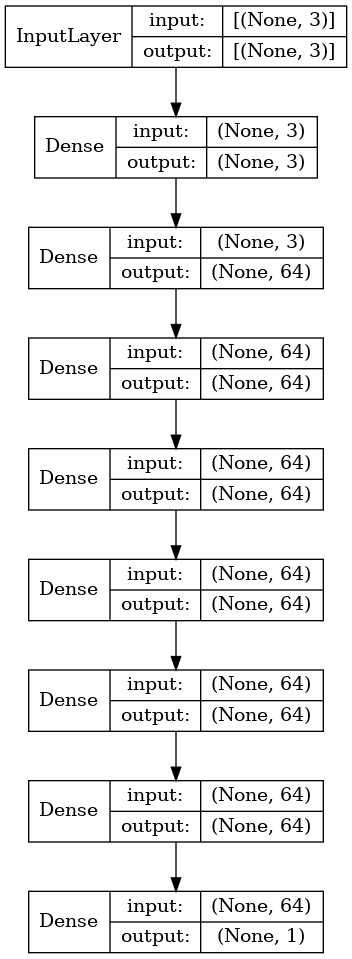

In [3]:
model = create_model(6)
plot_model(model, show_shapes=True, show_layer_names=False)

# 2. Making Predictions
### Let's compare the neural net to the catalog

The proper elements of 3 Juno are: [a = 2.669387, e = 0.233766, sin(I) = 0.229454]

The proper elements of 4 Vesta are: [a = 2.361512, e = 0.099826, sin(I) = 0.111464]

The proper elements of 5 Astraea are: [a = 2.576956, e = 0.185096, sin(I) = 0.079498]
 

In [4]:
names = ['Juno','Vesta','Astraea']
elem_Juno = [2.669387,0.233766,0.229454]
elem_Vesta = [2.361512,0.099826,0.111464]
elem_Astraea = [2.576956,0.185096,0.079498]

elements = np.array([elem_Juno,elem_Vesta,elem_Astraea])

### We can fit the just the visible or infrared ensenbles individually by providing the elements and the location of the ensemble weights

In [5]:
predicted_albedos = fit_ensemble('./vis_ensemble',elements)

In [6]:
vis_albedos, vis_sigma_pred = predicted_albedos
for i in range(len(names)):
    print(r"Prediction for "+names[i]+" log_10(p_V)= "+str(vis_albedos[i])+" sigma_pred_vis = "+str(vis_sigma_pred[i]))

Prediction for Juno log_10(p_V)= -0.78106385 sigma_pred_vis = 0.065634966
Prediction for Vesta log_10(p_V)= -0.49411646 sigma_pred_vis = 0.029655669
Prediction for Astraea log_10(p_V)= -0.79779243 sigma_pred_vis = 0.0534194


### We can also find the standard deviation of the belt wrt either albedo, by pointing to the correct weight file

In [7]:
vis_sigma_belt = fit_belt('./std_belt_models/bestmodel_vis.h5',elements)
for i in range(len(names)):
    print(r"Prediction for "+names[i]+" sigma_belt_vis = "+str(vis_sigma_belt[i]))

Prediction for Juno sigma_belt_vis = 0.28124452
Prediction for Vesta sigma_belt_vis = 0.12863916
Prediction for Astraea sigma_belt_vis = 0.36394697


### We can compare this to the cataloge and see they are identical to the values for asteroids number 3 & 5

In [8]:
catalogue = pd.read_csv('albedos_murray_2023.csv')
catalogue.iloc[2:5,:]

,number,a,ecc,sinI,V albedo,V albedo err,IR albedo,IR albedo err,Diameter,Diameter err,family,sigma_pred_vis,pred_vis,sigma_belt_vis,sigma_pred_ir,pred_ir,sigma_belt_ir
2,3,2.669387,0.233766,0.229454,0.1795,0.030418,0.2515,0.076500,292.2265,44.201537,3.0,0.065635,-0.781065,0.281245,0.065322,-0.616539,0.293168
3,4,2.361512,0.099826,0.111464,NaN,NaN,NaN,NaN,NaN,NaN,4.0,0.029656,-0.494117,0.128640,0.031308,-0.320720,0.122843
4,5,2.576956,0.185096,0.079498,0.2780,0.029954,0.3850,0.026627,107.4960,2.427540,NaN,0.053419,-0.797793,0.363948,0.053190,-0.626494,0.355671


# 3. Checking Predictions

### Let's check our predictions of Juno's albedo as an example

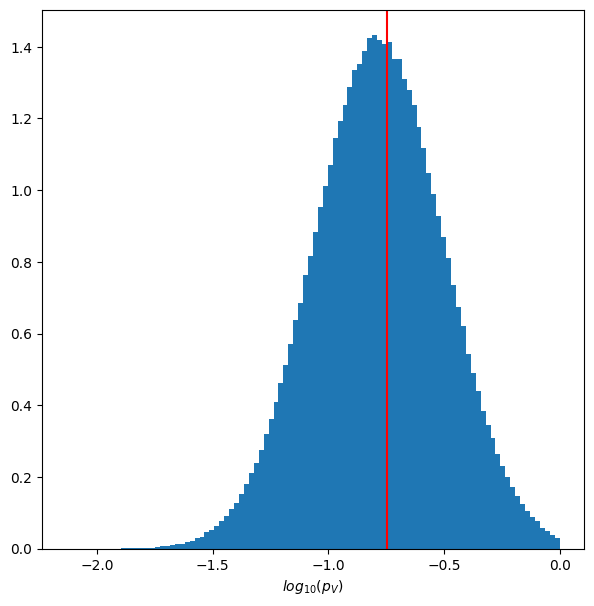

In [9]:
# since sigma_belt > sigma_pred for juno, I approximate the total uncertainty with just sigma_belt. 
draws = np.random.normal(vis_albedos[0],vis_sigma_belt[0],int(1e6)) #the pdf in log-albedo is approximately normal, so generate draws
draws = draws[draws<0] #remove unphysical albedos
fig,ax = plt.subplots(figsize=(7,7)) 
ax.hist(draws,bins=100,density=True) #plot distribution of log albedo
ax.set_xlabel(r"$log_{10}(p_V)$")
ax.axvline(np.log10(catalogue['V albedo'].iloc[2]),c='r') #plot NEOWISE measured albedo
plt.show()

#### As expected our predicitions agree well with the NEOWSIE measurment 

### Let's try for a more homogenous region of the belt:

In [10]:
elem_34654 = [2.133670,0.010125,0.030285]
elements = np.array([elem_34654])
predicted_albedos = fit_ensemble('./vis_ensemble',elements)
vis_albedos, vis_sigma_pred = predicted_albedos
print(r"Prediction for "+'34654'+" log_10(p_V)= "+str(vis_albedos[0])+" sigma_pred_vis = "+str(vis_sigma_pred[0]))

Prediction for 34654 log_10(p_V)= -0.59974617 sigma_pred_vis = 0.08969776


In [11]:
vis_sigma_belt = fit_belt('./std_belt_models/bestmodel_vis.h5',elements)
print(r"Prediction for "+'34654'+" sigma_belt_vis = "+str(vis_sigma_belt[0]))

Prediction for 34654 sigma_belt_vis = 0.036699045


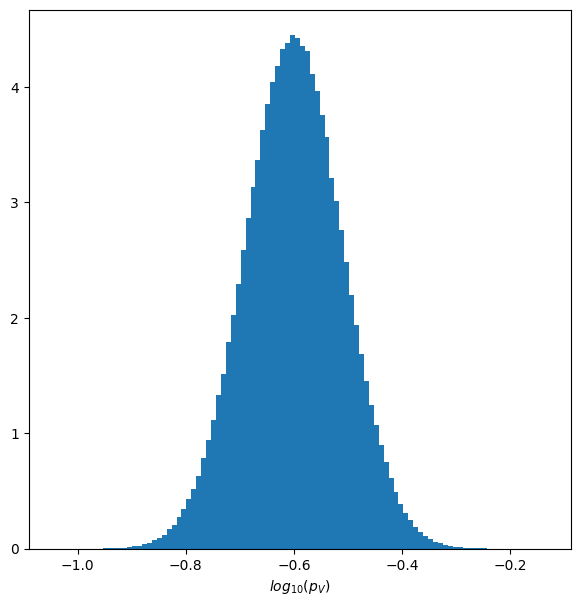

In [12]:
# here sigma_pred dominates, so we'll approximate in the opposite way. 
draws = np.random.normal(vis_albedos,vis_sigma_pred,int(1e6)) #the pdf in log-albedo is approximately normal, so generate draws
draws = draws[draws<0] #remove unphysical albedos
fig,ax = plt.subplots(figsize=(7,7)) 
ax.hist(draws,bins=100,density=True) #plot distribution of log albedo
ax.set_xlabel(r"$log_{10}(p_V)$")
ax.axvline(np.log10(catalogue['V albedo'].iloc[34654]),c='r') #plot NEOWISE measured albedo
plt.show()

#### In this case, there's no corresonding observation from NEOWISE to compare to, but the position in the belt can still give us a constraint on the albedo.  Since this asteroid is from a homogenous region of the belt, the constraint is sharper than that for JUNO.